In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
moodledf = pd.read_csv("moodle_issueinformation.csv",sep=';')
apachedf = pd.read_csv("apache_issueinformation.csv",sep=';')
atlassiandf = pd.read_csv("jira_issueinformation.csv",sep=';')
dflist = [moodledf,apachedf,atlassiandf]
apachedf['createdate'].min()
test = apachedf[apachedf['createdate'].str.startswith('00')] 
test['createdate'].min()

'0010-04-03'

In [3]:
test['createdate'].max()

'0012-10-19'

# Fix apache date

In [4]:
for key,issue in tqdm(apachedf.iterrows(),total=len(apachedf)):
    createdate = issue['createdate']
    if(createdate.startswith('00')):
        apachedf.iloc[key]['createdate'] = '2'+createdate[1:]

In [5]:
apachedf['createdate'].min()

'2000-10-19'

# Preprocess

In [6]:
for i in range(len(dflist)):
    dflist[i] = dflist[i][['issuekey', 'createdate']].groupby(['createdate'], as_index=False).agg('count')
    # test = test.sort_values('issuekey',ascending = False)
    dflist[i].rename(columns={'issuekey': 'issue'}, inplace=True)

In [7]:
dflist[1]['createdate'].min()

'2000-10-19'

In [8]:
dflist[0]['createdate'].max()

'2019-05-22'

In [9]:
for i in range(len(dflist)):
    dflist[i]['createdate'] = pd.to_datetime(dflist[i]['createdate'], format='%Y-%m-%d')
    dflist[i]['createdate'] = dflist[i]['createdate'].apply(lambda dt: dt.replace(day=1))

In [10]:
dflist[1].head()

,createdate,issue
0,2000-10-01,1
1,2000-10-01,1
2,2000-11-01,1
3,2000-12-01,1
4,2000-12-01,1


In [11]:
# y = test.resample('MS',level=1).sum()
# y = test.groupby(pd.Grouper(freq='MS', level=-1))
# y = test.groupby(['createdate']).sum()
# y = y.reset_index()
# y.head()
for i in range(len(dflist)):
    dflist[i] = dflist[i].groupby(['createdate']).sum()
    dflist[i] = dflist[i].reset_index()
dflist[1].head()


,createdate,issue
0,2000-10-01,2
1,2000-11-01,1
2,2000-12-01,3
3,2001-01-01,12
4,2001-02-01,69


In [12]:
dflist[2].head()

,createdate,issue
0,1982-11-01,1
1,2002-02-01,51
2,2002-03-01,105
3,2002-04-01,70
4,2002-05-01,95


In [13]:
dflist[2] = dflist[2].drop(0, axis=0)

In [14]:
dflist[2].head()

,createdate,issue
1,2002-02-01,51
2,2002-03-01,105
3,2002-04-01,70
4,2002-05-01,95
5,2002-06-01,72


# Combine 3 platforms

In [15]:
platf = ['Moodle','Apache','Atlassian']
for i in range(len(dflist)):
    dflist[i]['Platform'] = platf[i]
df = dflist[0].copy()
df = df.append(dflist[1])
df = df.append(dflist[2])
df['Platform'].unique()

array(['Moodle', 'Apache', 'Atlassian'], dtype=object)

# Visualization

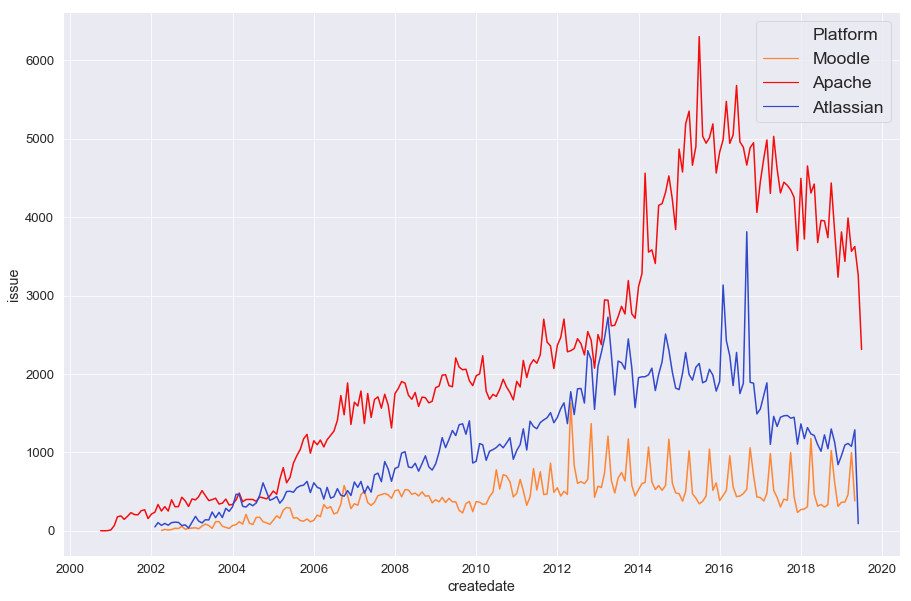

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=2)  
torplat = ["#FF8633", "#F30D0D","#3249CC"]
sns.lineplot(x='createdate',y='issue',hue='Platform',linewidth=1.5,data=df,ax=ax,palette=sns.color_palette(torplat))
plt.show()

## Status

In [51]:
status = df[['issuekey', 'createdate','status']].groupby(['createdate','status'], as_index=False).agg('count')
# test = test.sort_values('issuekey',ascending = False)
status.rename(columns={'issuekey': 'issue'}, inplace=True)

In [52]:
status.head()

,createdate,status,issue
0,2002-04-25,Closed,4
1,2002-05-15,Closed,2
2,2002-05-17,Closed,10
3,2002-05-17,Open,1
4,2002-05-27,Closed,2


In [53]:
status['createdate'] = pd.to_datetime(status['createdate'], format='%Y-%m-%d')
status['createdate'] = status['createdate'].apply(lambda dt: dt.replace(day=1))

In [54]:
status.head()

,createdate,status,issue
0,2002-04-01,Closed,4
1,2002-05-01,Closed,2
2,2002-05-01,Closed,10
3,2002-05-01,Open,1
4,2002-05-01,Closed,2


In [55]:
y2 = status.groupby(['status','createdate']).sum()
y2 = y2.reset_index()
y2.head()

,status,createdate,issue
0,Changes Required,2017-01-01,18
1,Changes Required,2017-02-01,3
2,Changes Required,2017-03-01,4
3,Changes Required,2017-04-01,4
4,Changes Required,2017-05-01,4


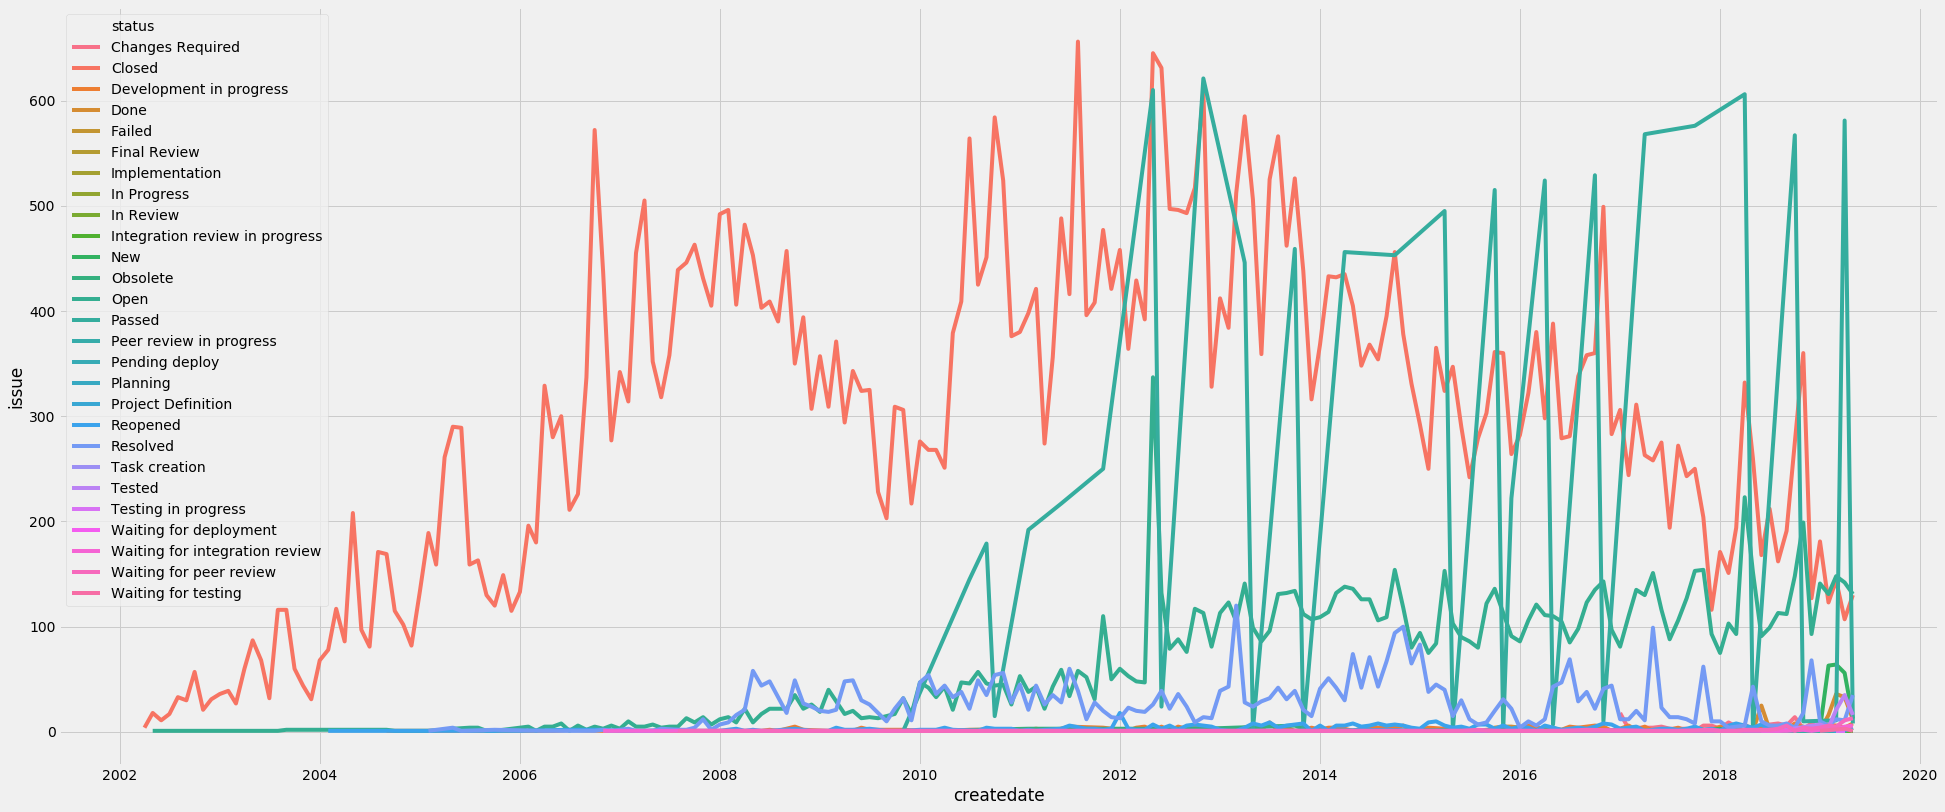

In [56]:
fig, ax = plt.subplots(figsize=(30, 13))
sns.lineplot(x='createdate',y='issue',hue='status',data=y2,ax=ax)
plt.show()

In [70]:
from bokeh.palettes import Spectral4
from bokeh.palettes import Dark2_5 as palette
from bokeh.plotting import figure, output_file
from bokeh.io import output_notebook, show
import itertools

#colors has a list of colors which can be used in plots 
colors = itertools.cycle(palette) 
output_notebook()

p = figure(plot_width=1500, plot_height=1000, x_axis_type="datetime")
p.title.text = 'Click on legend entries to hide the corresponding lines'

for status,color in zip(y2['status'].unique(),colors):
    temp = y2[(y2['status']==status)]
    p.line(temp['createdate'], temp['issue'],color=color, line_width=2, alpha=0.8,legend =status)

p.legend.location = "top_left"
p.legend.click_policy="hide"
output_file("interactive_legend.html", title="interactive_legend.py example")
show(p)


Loading BokehJS ...

## Bug

In [44]:
bug = df[(df['type']=='Bug')][['issuekey', 'createdate']].groupby(['createdate'], as_index=False).agg('count')
# test = test.sort_values('issuekey',ascending = False)
bug.rename(columns={'issuekey': 'issue'}, inplace=True)

In [45]:
bug.head()

,createdate,issue
0,2002-04-25,1
1,2002-05-15,2
2,2002-05-17,2
3,2002-05-27,1
4,2002-05-29,2


In [46]:
bug['createdate'].min()

'2002-04-25'

In [47]:
bug['createdate'].max()

'2019-05-22'

In [48]:
bug['createdate'] = pd.to_datetime(bug['createdate'], format='%Y-%m-%d')
bug = bug.set_index('createdate')

In [49]:
y2 = bug['issue'].resample('MS').mean()

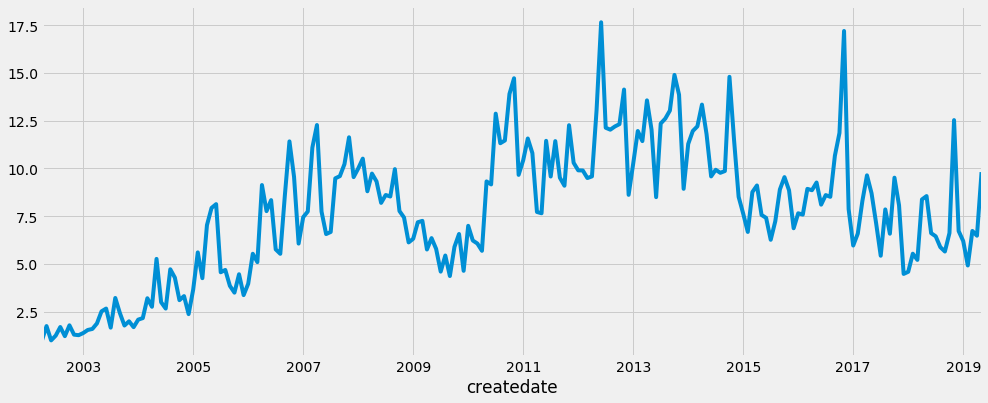

In [50]:
plt.style.use('fivethirtyeight')
y2.plot(figsize=(15, 6))
plt.show()